## Very Simple Markov Perfect Industry Dynamics in Python

#### John Stachurski

In this note we implement the algorithm for computing Markov perfect equilibria presented and analyzed in the paper [Very Simple Markov-Perfect Industry Dynamics: Theory
](https://www.econometricsociety.org/publications/econometrica/2018/03/01/very-simple-markov-perfect-industry-dynamics-theory) 

The paper, written by Jaap H. Abbring, Jeffrey R. Campbell, Jan Tilly, and Nan Yang, is published in the March 2018 issue of Econometrica

Our implementation of their algorithm uses Python

We use Numba and JIT compilation to generate fast, efficient machine code

Rather than discretizing the exogenous state, we treat it as continuous and apply linear interpolation where necessary

On our workstation, the algorithm can compute an equilibrium consisting of around 30 firms in just over 5 seconds

In addition to implementing the algorithm, we run some simulations to help build intuition as to the predictions of the model

Two great things about this particular model of oligopolistic competition are:

1. unlike many related papers, a unique symmetric Markov perfect algorithm is known to exist and, 

2. the authors provide an algorithm guaranteed to converge to this equilibrium.

### Set Up

We begin with some imports:

In [193]:
import numpy as np
import quantecon as qe
from numba import njit
from lininterp import interp1d
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.axes3d import Axes3D
from matplotlib import cm


The state process is

$$ y_{t+1} = \rho y_t + b + \xi_{t+1} $$

where $-1 < \rho < 1$ and $\{ \xi_t \}$ is iid and uniform on $[-\sigma, \sigma]$


The parameters in this process are set to

In [194]:
ρ = 0.95
b = 10.0
σ = 1.0

Iterating on the bound $y_{t+1} \leq \rho y_t + b + \sigma$ yields

$$
    y_{t+1} \leq (b + \sigma) \frac{1 - \rho^{t+1}}{1 - \rho} + \rho^{t+1} y_0
$$

Taking the limit in this expression and then repeating the exercise with the reverse bound $y_{t+1} \geq \rho y_t + b - \sigma$, we find
that the stationary distribution for $y_t$ is supported on the interval

$$ I := \left[ \frac{b - \sigma}{1 - \rho}, \, \frac{b + \sigma}{1 - \rho} \right] $$

Let's set up a grid over $y$ values, covering the stationary distribution, which we can use to interpolate functions over:

In [195]:
y_min = (b - σ) / (1 - ρ)
y_max = (b + σ) / (1 - ρ)
y_grid_size = 12
y_grid = np.linspace(y_min, y_max, y_grid_size)

We'll use draws from the innovation $\xi$ to integrate via Monte Carlo:

In [196]:
mc_size = 250
ξ_draws = np.random.uniform(low=-σ, high=σ, size=mc_size)

The discount rate is

In [197]:
β = 0.9

Entry costs are increasing in the number of firms and decreasing in the state:

In [130]:
@njit
def ϕ(n, y):
    return np.exp(4.0 * n - 0.5 * y)

The profit function $\pi$ is decreasing in the number of firms and increasing in the exogenous state:

$$ \pi(n, y) = d y^q - n^\gamma $$

In [144]:
d = 1.0
γ = 2.0
q = 1.25

@njit
def π(n, y):
    return d * y**q - n**γ

Set `n_max` to the first $n$ such that profits are negative for all possible values of $y_t$.

In [145]:
n_max = np.int(np.ceil((d * y_max**(q/γ))))
n_size = n_max + 1

In [146]:
n_max

30

In the text, as in the original paper, `n_max` will be represented by $\check n$.

### Algorithm for Computing the Equilibrium

We use the algorithm described in Abbring et al. (2018)

As in that paper, $v_E(j, y)$ is the post-entry stage value of firm number $j$ in exogenous state $y$

Here, to match Python indexing, the first firm given the option to enter will be labeled "firm 0" rather than "firm 1"

First we solve for $v_E(\check n, \cdot)$ as the fixed point of

$$ (Tf)(y) = 
   \max 
   \left\{
       0, \, \beta \, \mathbb E_y 
        [ \pi(\check n, Y') + 
           f(Y')
        ]
   \right\}
$$
         

Next, for $n = \check n -1, \check n - 2, \ldots, 1$, we solve the family of contractions

$$ (T_n f)(y) = 
   \max 
   \left\{
       0, \, \beta  \, \mathbb E_y 
        [ \pi(n, Y') + 
           \mathbb 1\{\mu(n, Y') = n\} f(Y') +
           \mathbb 1\{\mu(n, Y') > n\} g_n(Y')
        ]
   \right\}
$$

Here

* $g_n(Y') := v_E(\mu(n, Y'), Y')$
* $\mu(n, y) := n + \sum_{m=n+1}^{\check n} \mathbb 1\{v_E(m, y) > \phi(m, y)\}$ where $v_E(m, \cdot)$ is the fixed point of $T_m$

The expectations above will be approximated by Monte Carlo estimates of the form

$$
    \hat E_y [ h(Y')]
     := \frac{1}{m} \sum_{i=1}^m
         [ h( \rho y + b + \xi_i) ]
$$


Here's a function that computes $\mu(n, y)$ given $v_E$:

In [147]:
@njit
def μ(n, y, v_E):
    μ_n = n
    if n < n_max:
        for m in range(n + 1, n_size):  
            if interp1d(y_grid, v_E[m, :], y) > ϕ(m, y):
                μ_n += 1
    return μ_n

Next, we provide a function factory, the job of which is to

* take $v_E$ and $n$ as inputs, and
* create a Bellman operator $T_n$ corresponding to the definition given above.

In [148]:
def build_bellman_operator(v_E, n):
    
    @njit
    def firm_bellman(f_in):
        # Set up
        def f(x):
            return interp1d(y_grid, f_in, x)
        f_out = np.empty_like(f_in)

        for i, y in enumerate(y_grid):
            t = 0.0
            for ξ in ξ_draws:
                yp = ρ * y + b + ξ
                t += π(n, yp) 
                μ_n = μ(n, yp, v_E)
                if μ_n == n:
                    t += f(yp)
                else:
                    t += interp1d(y_grid, v_E[μ_n, :], yp)
            f_out[i] = max(0, β * (t / mc_size))
        return f_out
    
    return firm_bellman


Here's a function to iterate to convergence with each $T_n$, starting at initial condition $f \equiv 0$

The function returns the (approximate) fixed point of $T_n$

In [186]:
def iterate(operator, f_init, tol=0.0001, max_iter=500, verbose=True):
    error = tol + 1
    i = 0
    f_in = f_init
    while i < max_iter and error > tol:
        f_out = operator(f_in)
        error = np.max(np.abs(f_out - f_in))
        f_in = f_out
        i += 1
    if verbose:
        print(f'  Iteration converged after {i} step(s)')
    return f_out

### Computation of Equilibrium Values and Actions

Now let's use the code above to compute the equilibrium corresponding to our parameters



In [191]:
v_E = np.empty((n_size, y_grid_size))

n = n_max
f_init = np.zeros(y_grid_size)
while n >= 0:
    print(f"Solving v_E(n, ) for firm {n}")
    operator = build_bellman_operator(v_E, n)
    f_out = iterate(operator, f_init)
    v_E[n, :] = f_out
    n = n - 1


Solving v_E(n,  ) for firm 30
  Iteration converged after 1 step(s)
Solving v_E(n,  ) for firm 29
  Iteration converged after 23 step(s)
Solving v_E(n,  ) for firm 28
  Iteration converged after 62 step(s)
Solving v_E(n,  ) for firm 27
  Iteration converged after 115 step(s)
Solving v_E(n,  ) for firm 26
  Iteration converged after 118 step(s)
Solving v_E(n,  ) for firm 25
  Iteration converged after 81 step(s)
Solving v_E(n,  ) for firm 24
  Iteration converged after 48 step(s)
Solving v_E(n,  ) for firm 23
  Iteration converged after 2 step(s)
Solving v_E(n,  ) for firm 22
  Iteration converged after 2 step(s)
Solving v_E(n,  ) for firm 21
  Iteration converged after 2 step(s)
Solving v_E(n,  ) for firm 20
  Iteration converged after 2 step(s)
Solving v_E(n,  ) for firm 19
  Iteration converged after 2 step(s)
Solving v_E(n,  ) for firm 18
  Iteration converged after 2 step(s)
Solving v_E(n,  ) for firm 17
  Iteration converged after 2 step(s)
Solving v_E(n,  ) for firm 16
  Iteratio

Next let's build $\alpha_E$

In [192]:
α_E = np.zeros((n_size, y_grid_size), dtype=np.int)
for n in range(n_size):
    for i, y in enumerate(y_grid):
        if interp1d(y_grid, v_E[n, :], y) > ϕ(n, y):
            α_E[n, i] = 1

In studying the equilibrium, let's start by looking at the number of entrants for each level of the exogeneous shock.

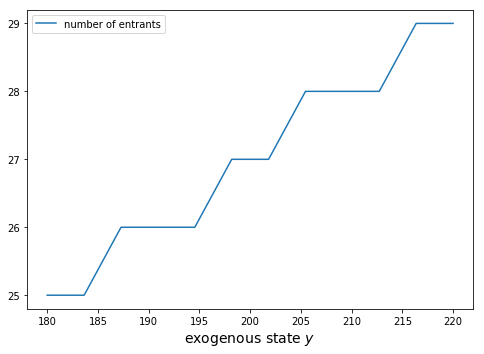

In [190]:
num_entrants = np.sum(α_E, axis=0)

fig, ax = plt.subplots(figsize=(8, 5.5))
ax.plot(y_grid, num_entrants, label='number of entrants')
ax.set_yticks(range(num_entrants.min(), num_entrants.max()+1))
ax.legend()
ax.set_xlabel('exogenous state $y$', fontsize=14)
plt.show()

Not surprisingly, a higher exogenous state draws in more firms

Next, let's look at $v_E$, which is a function of the exogenous state and the firm number $j$

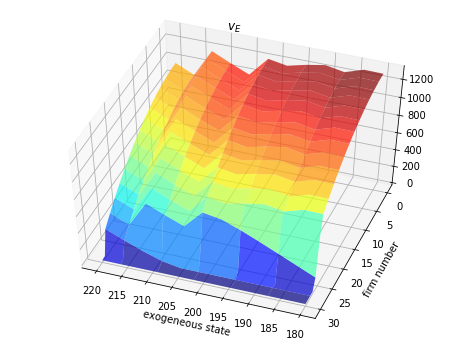

In [180]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ng, yg = np.meshgrid(list(range(n_size)), y_grid)
ax.plot_surface(yg,
                ng,
                v_E.T,
                rstride=2, cstride=2,
                cmap=cm.jet,
                alpha=0.7,
                linewidth=0.25)
ax.view_init(50, 110)
ax.set_ylabel("firm number")
ax.set_xlabel("exogeneous state")
plt.show()

Clearly value is not monotone in the exogenous state $y$ for many of the firms

The reason is that a higher value of $y$ encourages greater entry, as seen above

Greater entry reduces value for encumbent firms

Now let's build and plot $v_S$

In [181]:
v_S = np.empty((n_size, y_grid_size))
for n in range(n_size):
    for i, y in enumerate(y_grid):
        t = 0.0
        for ξ in ξ_draws:
            yp = ρ * y + b + ξ
            t += π(n, yp) + interp1d(y_grid, v_E[μ(n, y, v_E), :], yp)
        v_S[n, i] = t / mc_size

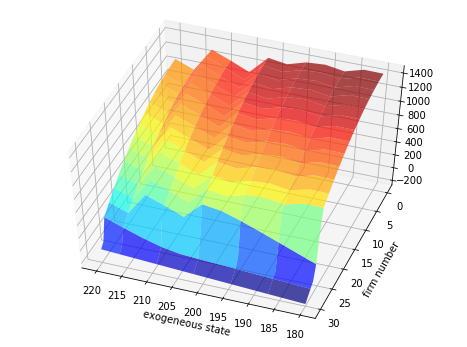

In [182]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ng, yg = np.meshgrid(list(range(n_size)), y_grid)
ax.plot_surface(yg,
                ng,
                v_S.T,
                rstride=2, cstride=2,
                cmap=cm.jet,
                alpha=0.7,
                linewidth=0.25)
ax.view_init(50, 110)
ax.set_ylabel("firm number")
ax.set_xlabel("exogeneous state")
plt.show()